In [1]:
pip install pandas matplotlib seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


📥 Loading dataset...

🔍 Inspecting Data Structure:
✅ Data type: <class 'dict'>
✅ Number of entries: 1000
✅ Sample keys (first 5): ['21645374', '16418930', '9488747', '17208539', '10808977']

✅ Sample entry structure (PMID: 21645374 ):
✅ Keys in sample entry: ['QUESTION', 'CONTEXTS', 'LABELS', 'MESHES', 'YEAR', 'reasoning_required_pred', 'reasoning_free_pred', 'final_decision', 'LONG_ANSWER']

✅ Sample entry content:
QUESTION: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
CONTEXTS: ['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recogni

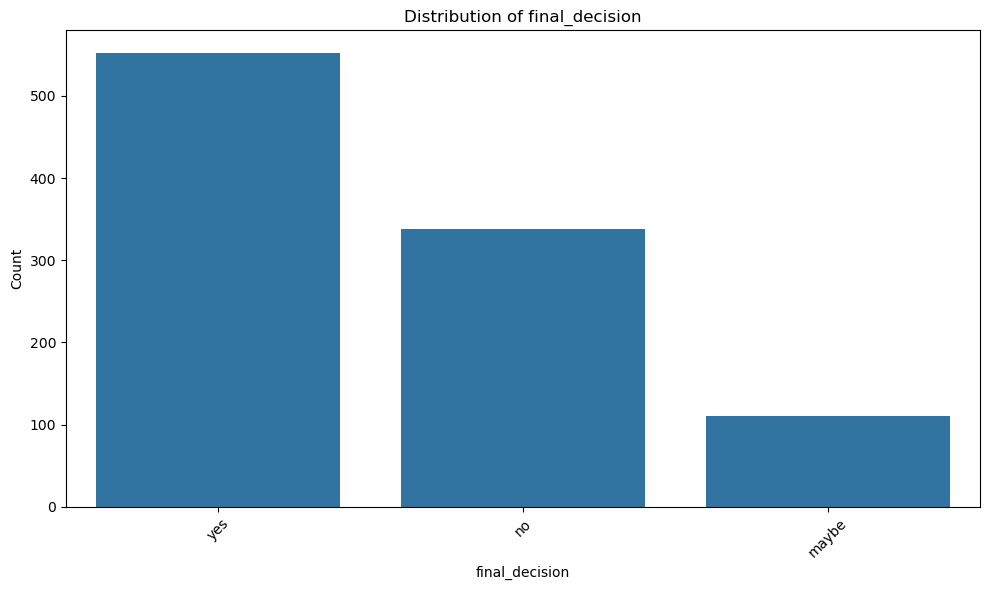


✅ Label distribution:
  - yes: 552 (55.2%)
  - no: 338 (33.8%)
  - maybe: 110 (11.0%)

📊 Text Length Distributions:
Available fields in sample entry:
['QUESTION', 'CONTEXTS', 'LABELS', 'MESHES', 'YEAR', 'reasoning_required_pred', 'reasoning_free_pred', 'final_decision', 'LONG_ANSWER']
✅ Found question field: 'QUESTION'
✅ Found answer field: 'LONG_ANSWER'
⚠️ Possible context field: 'CONTEXTS'


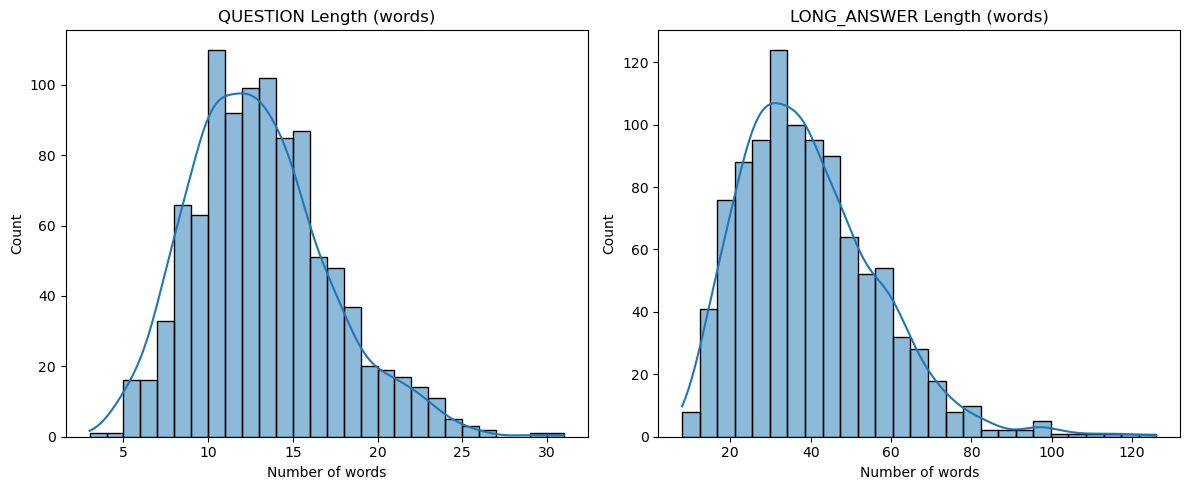


✅ Text length statistics (in words):
  - QUESTION: min=3, max=31, avg=12.9
  - LONG_ANSWER: min=8, max=126, avg=39.7

📊 Duplicate Check:
🔍 Unique questions: 1000 / 1000
✅ No duplicate questions found.

🔎 Sample Entries:

📌 Sample 1 (PMID: 18319270) --------
QUESTION: Does confined placental mosaicism account for adverse perinatal outcomes in IVF pregnancies?
LONG_ANSWER: The incidence of CPM is not increased in IVF/ICSI pregnancies compared with spontaneous conceptions. CPM probably does not account for the adverse perinatal outcomes following IVF/ICSI.
final_decision: no

📌 Sample 2 (PMID: 18179827) --------
QUESTION: Does topical ropivacaine reduce the post-tonsillectomy morbidity in pediatric patients?
LONG_ANSWER: Locally 1.0% ropivacaine administration significantly relieves the pain of pediatric tonsillectomy and, it is a safe and effective method. High concentrations of ropivaciane may produce clinically significant pain relief. It is more effective to reduce of post-operative 

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

# PubMedQA Labeled Dataset
def load_pubmedqa_labeled(path="/Users/casey/Documents/GitHub/LLM_Healthcare/ori_pqal.json"):
    """Load the PubMedQA dataset from JSON file"""
    with open(path, "r") as f:
        data = json.load(f)
    return data

# Inspect data structure to understand format
def inspect_data_structure(data):
    """Print out information about the dataset structure"""
    print("✅ Data type:", type(data))
    
    if isinstance(data, dict):
        print("✅ Number of entries:", len(data))
        print("✅ Sample keys (first 5):", list(data.keys())[:5])
        
        # Get a sample PubMed ID (first key)
        sample_key = list(data.keys())[0]
        sample_entry = data[sample_key]
        
        print("\n✅ Sample entry structure (PMID:", sample_key, "):")
        print("✅ Keys in sample entry:", list(sample_entry.keys()))
        
        # Print sample data content
        print("\n✅ Sample entry content:")
        for k, v in sample_entry.items():
            if isinstance(v, str) and len(v) > 100:
                print(f"{k}: {v[:100]}...")  # Truncate long text
            else:
                print(f"{k}: {v}")
    else:
        print("⚠️ Data is not in the expected dictionary format")

# Basic summary statistics
def basic_summary(data):
    """Provide basic summary statistics about the dataset"""
    if not isinstance(data, dict):
        print("⚠️ Data is not in the expected dictionary format")
        return
    
    total_entries = len(data)
    print(f"✅ Total entries: {total_entries}")
    
    # Check if entries have consistent structure
    key_counts = Counter()
    for pmid, entry in data.items():
        if isinstance(entry, dict):
            for key in entry.keys():
                key_counts[key] += 1
    
    print("\n✅ Fields present in the dataset:")
    for key, count in key_counts.most_common():
        print(f"  - {key}: present in {count}/{total_entries} entries ({count/total_entries*100:.1f}%)")

# Label Distribution Analysis
def plot_label_distribution(data):
    """Plot the distribution of answer labels and return the counts"""
    if not isinstance(data, dict):
        print("⚠️ Data is not in the expected dictionary format")
        return None, 0
    
    # Extract final answers
    # Adjust the field name based on your data structure
    label_field = 'final_decision'  # This might be 'final_answer', 'label', etc.
    
    # Check available fields in the first entry to help the user
    sample_entry = next(iter(data.values()))
    potential_label_fields = ['final_decision', 'final_answer', 'label', 'LABEL', 'answer_type', 'FINAL_DECISION']
    
    # Print all fields in the sample entry to help debugging
    print("Available fields in sample entry:")
    print(list(sample_entry.keys()))
    
    # Try to find the correct label field
    found_field = False
    for field in potential_label_fields:
        if field in sample_entry:
            label_field = field
            print(f"✅ Found label field: '{field}'")
            found_field = True
            break
    
    if not found_field:
        print(f"⚠️ Could not find any standard label field. Please specify the correct field name.")
        # If we couldn't find any standard field, try to guess if there's something that looks like a label
        for field in sample_entry.keys():
            if any(label_hint in field.lower() for label_hint in ['label', 'decision', 'answer', 'final']):
                print(f"Possible label field: '{field}'")
    
    # Extract labels
    labels = []
    for pmid, entry in data.items():
        if isinstance(entry, dict) and label_field in entry:
            labels.append(entry[label_field])
    
    if not labels:
        print(f"⚠️ No '{label_field}' field found in entries or it contains no values.")
        
        # Print a complete example of the first entry to help debug
        print("\nExample entry structure:")
        for key, value in sample_entry.items():
            print(f"  {key}: {type(value)}")
            if isinstance(value, (str, int, float, bool)):
                print(f"    Value: {value}")
            elif isinstance(value, dict) and len(value) < 5:
                print(f"    Content: {value}")
            elif isinstance(value, (list, tuple)) and len(value) < 5:
                print(f"    Content: {value}")
        
        return None, 0
    
    # Create label counts safely
    try:
        label_counts = pd.Series(labels).value_counts()
        
        # Plot the distribution
        plt.figure(figsize=(10, 6))
        sns.barplot(x=label_counts.index, y=label_counts.values)
        plt.title(f"Distribution of {label_field}")
        plt.xlabel(label_field)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("\n✅ Label distribution:")
        total_labels = len(labels)
        for label, count in label_counts.items():
            print(f"  - {label}: {count} ({count/total_labels*100:.1f}%)")
        
        # Return the label counts and total for potential further use
        return label_counts, total_labels
        
    except Exception as e:
        print(f"⚠️ Error creating label distribution: {str(e)}")
        print(f"Labels found: {labels[:5]}... (total: {len(labels)})")
        return None, 0

# Text Length Analysis
def plot_text_lengths(data):
    """Analyze and plot the length of text fields"""
    if not isinstance(data, dict):
        print("⚠️ Data is not in the expected dictionary format")
        return
    
    # Try to determine the correct field names based on the first entry
    sample_entry = next(iter(data.values()))
    
    # Print available fields for debugging
    print("Available fields in sample entry:")
    print(list(sample_entry.keys()))
    
    # Common field names for question, context, and answer
    potential_question_fields = ['question', 'QUESTION', 'Question']
    potential_context_fields = ['context', 'CONTEXT', 'Context', 'abstract', 'ABSTRACT', 'Abstract']
    potential_answer_fields = ['long_answer', 'LONG_ANSWER', 'answer', 'ANSWER', 'Answer']
    
    question_field = None
    context_field = None
    answer_field = None
    
    # Find the actual field names in the data
    for field in potential_question_fields:
        if field in sample_entry:
            question_field = field
            print(f"✅ Found question field: '{field}'")
            break
            
    for field in potential_context_fields:
        if field in sample_entry:
            context_field = field
            print(f"✅ Found context field: '{field}'")
            break
            
    for field in potential_answer_fields:
        if field in sample_entry:
            answer_field = field
            print(f"✅ Found answer field: '{field}'")
            break
    
    # Look for potential fields by keyword if standard fields not found
    if not question_field:
        for field in sample_entry.keys():
            if 'question' in field.lower():
                question_field = field
                print(f"⚠️ Possible question field: '{field}'")
                break
                
    if not context_field:
        for field in sample_entry.keys():
            if any(keyword in field.lower() for keyword in ['context', 'abstract', 'text']):
                context_field = field
                print(f"⚠️ Possible context field: '{field}'")
                break
                
    if not answer_field:
        for field in sample_entry.keys():
            if any(keyword in field.lower() for keyword in ['answer', 'response', 'result']):
                answer_field = field
                print(f"⚠️ Possible answer field: '{field}'")
                break
    
    # Initialize lists to store lengths
    question_lengths = []
    context_lengths = []
    answer_lengths = []
    
    # Calculate lengths
    if question_field:
        for pmid, entry in data.items():
            if question_field in entry and isinstance(entry[question_field], str):
                question_lengths.append(len(entry[question_field].split()))
                
    if context_field:
        for pmid, entry in data.items():
            if context_field in entry and isinstance(entry[context_field], str):
                context_lengths.append(len(entry[context_field].split()))
                
    if answer_field:
        for pmid, entry in data.items():
            if answer_field in entry and isinstance(entry[answer_field], str):
                answer_lengths.append(len(entry[answer_field].split()))
    
    # Create plots for available data
    available_plots = []
    if question_lengths:
        available_plots.append(('question', question_field, question_lengths))
    if context_lengths:
        available_plots.append(('context', context_field, context_lengths))
    if answer_lengths:
        available_plots.append(('answer', answer_field, answer_lengths))
    
    num_plots = len(available_plots)
    
    if num_plots == 0:
        print("⚠️ No text length data available to plot")
        return
        
    try:
        fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 5))
        
        # Handle the case where there's only one plot
        if num_plots == 1:
            axes = [axes]
        
        # Create each plot
        for i, (plot_type, field_name, lengths) in enumerate(available_plots):
            sns.histplot(lengths, ax=axes[i], kde=True)
            axes[i].set_title(f"{field_name} Length (words)")
            axes[i].set_xlabel("Number of words")
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n✅ Text length statistics (in words):")
        if question_lengths:
            print(f"  - {question_field}: min={min(question_lengths)}, max={max(question_lengths)}, avg={sum(question_lengths)/len(question_lengths):.1f}")
        if context_lengths:
            print(f"  - {context_field}: min={min(context_lengths)}, max={max(context_lengths)}, avg={sum(context_lengths)/len(context_lengths):.1f}")
        if answer_lengths:
            print(f"  - {answer_field}: min={min(answer_lengths)}, max={max(answer_lengths)}, avg={sum(answer_lengths)/len(answer_lengths):.1f}")
            
    except Exception as e:
        print(f"⚠️ Error creating text length plots: {str(e)}")
        print(f"Available data: question={len(question_lengths)}, context={len(context_lengths)}, answer={len(answer_lengths)}")
        if available_plots:
            print("First few values of each:")
            for plot_type, field_name, lengths in available_plots:
                print(f"  - {field_name}: {lengths[:5]}")


# Check for Duplicates
def check_duplicates(data):
    """Check for duplicate questions in the dataset"""
    if not isinstance(data, dict):
        print("⚠️ Data is not in the expected dictionary format")
        return
        
    # Try to determine the question field name
    sample_entry = next(iter(data.values()))
    potential_question_fields = ['question', 'QUESTION', 'Question']
    
    question_field = None
    for field in potential_question_fields:
        if field in sample_entry:
            question_field = field
            break
    
    if not question_field:
        print("⚠️ Could not identify question field. Available fields are:")
        print(list(sample_entry.keys()))
        return
    
    # Extract questions
    questions = {}
    for pmid, entry in data.items():
        if question_field in entry:
            question = entry[question_field]
            if question in questions:
                questions[question].append(pmid)
            else:
                questions[question] = [pmid]
    
    # Find duplicates
    duplicates = {q: pmids for q, pmids in questions.items() if len(pmids) > 1}
    
    total = len(data)
    unique_questions = len(questions)
    print(f"🔍 Unique questions: {unique_questions} / {total}")
    
    if duplicates:
        print(f"⚠️ {len(duplicates)} questions have duplicate entries:")
        for i, (question, pmids) in enumerate(list(duplicates.items())[:5]):  # Show first 5
            print(f"  {i+1}. '{question[:50]}...' appears in {len(pmids)} entries: {pmids}")
        
        if len(duplicates) > 5:
            print(f"  ... and {len(duplicates)-5} more.")
            
        return duplicates
    else:
        print("✅ No duplicate questions found.")
        return None

# Sample Display
def print_random_sample(data, n=3):
    """Print a few random samples from the dataset"""
    if not isinstance(data, dict):
        print("⚠️ Data is not in the expected dictionary format")
        return
        
    # Get a few random keys
    import random
    sample_keys = random.sample(list(data.keys()), min(n, len(data)))
    
    # Identify the field names from the first sample
    sample_entry = data[sample_keys[0]]
    
    # Try to find the field names
    potential_fields = {
        'question': ['question', 'QUESTION', 'Question'],
        'context': ['context', 'CONTEXT', 'Context', 'abstract', 'ABSTRACT', 'Abstract'],
        'answer': ['long_answer', 'LONG_ANSWER', 'answer', 'ANSWER', 'Answer'],
        'label': ['final_answer', 'final_decision', 'label', 'LABEL', 'Label']
    }
    
    field_names = {}
    for field_type, candidates in potential_fields.items():
        for candidate in candidates:
            if candidate in sample_entry:
                field_names[field_type] = candidate
                break
    
    # Print the samples
    for i, key in enumerate(sample_keys):
        entry = data[key]
        print(f"\n📌 Sample {i+1} (PMID: {key}) --------")
        
        for field_type, field in field_names.items():
            if field in entry:
                value = entry[field]
                if isinstance(value, str) and len(value) > 300 and field_type == 'context':
                    print(f"{field}: {value[:300]}...")  # Truncate long context
                else:
                    print(f"{field}: {value}")

# Full EDA Pipeline
def run_eda(path="/Users/casey/Documents/GitHub/LLM_Healthcare/ori_pqal.json"):
    print("📥 Loading dataset...")
    data = load_pubmedqa_labeled(path)
    
    print("\n🔍 Inspecting Data Structure:")
    inspect_data_structure(data)
    
    print("\n📊 Basic Summary:")
    basic_summary(data)

    print("\n📊 Label Distribution:")
    label_counts, total_labels = plot_label_distribution(data)
    # The label_counts summary is already printed inside the function
    
    print("\n📊 Text Length Distributions:")
    plot_text_lengths(data)

    print("\n📊 Duplicate Check:")
    duplicates = check_duplicates(data)

    print("\n🔎 Sample Entries:")
    print_random_sample(data)

    return data

if __name__ == "__main__":
    # Run the EDA pipeline
    run_eda()

## 1. Dataset Overview and Context

In [10]:
print("PubMedQA Dataset Overview")
print("PubMedQA is a biomedical question answering dataset with 1,000 labeled examples.")
print("Each example contains a biomedical research question, context from scientific abstracts,")
print("and a labeled answer (yes/no/maybe) with a long-form explanation.")

PubMedQA Dataset Overview
PubMedQA is a biomedical question answering dataset with 1,000 labeled examples.
Each example contains a biomedical research question, context from scientific abstracts,
and a labeled answer (yes/no/maybe) with a long-form explanation.


## 2. Data Distribution Analysis

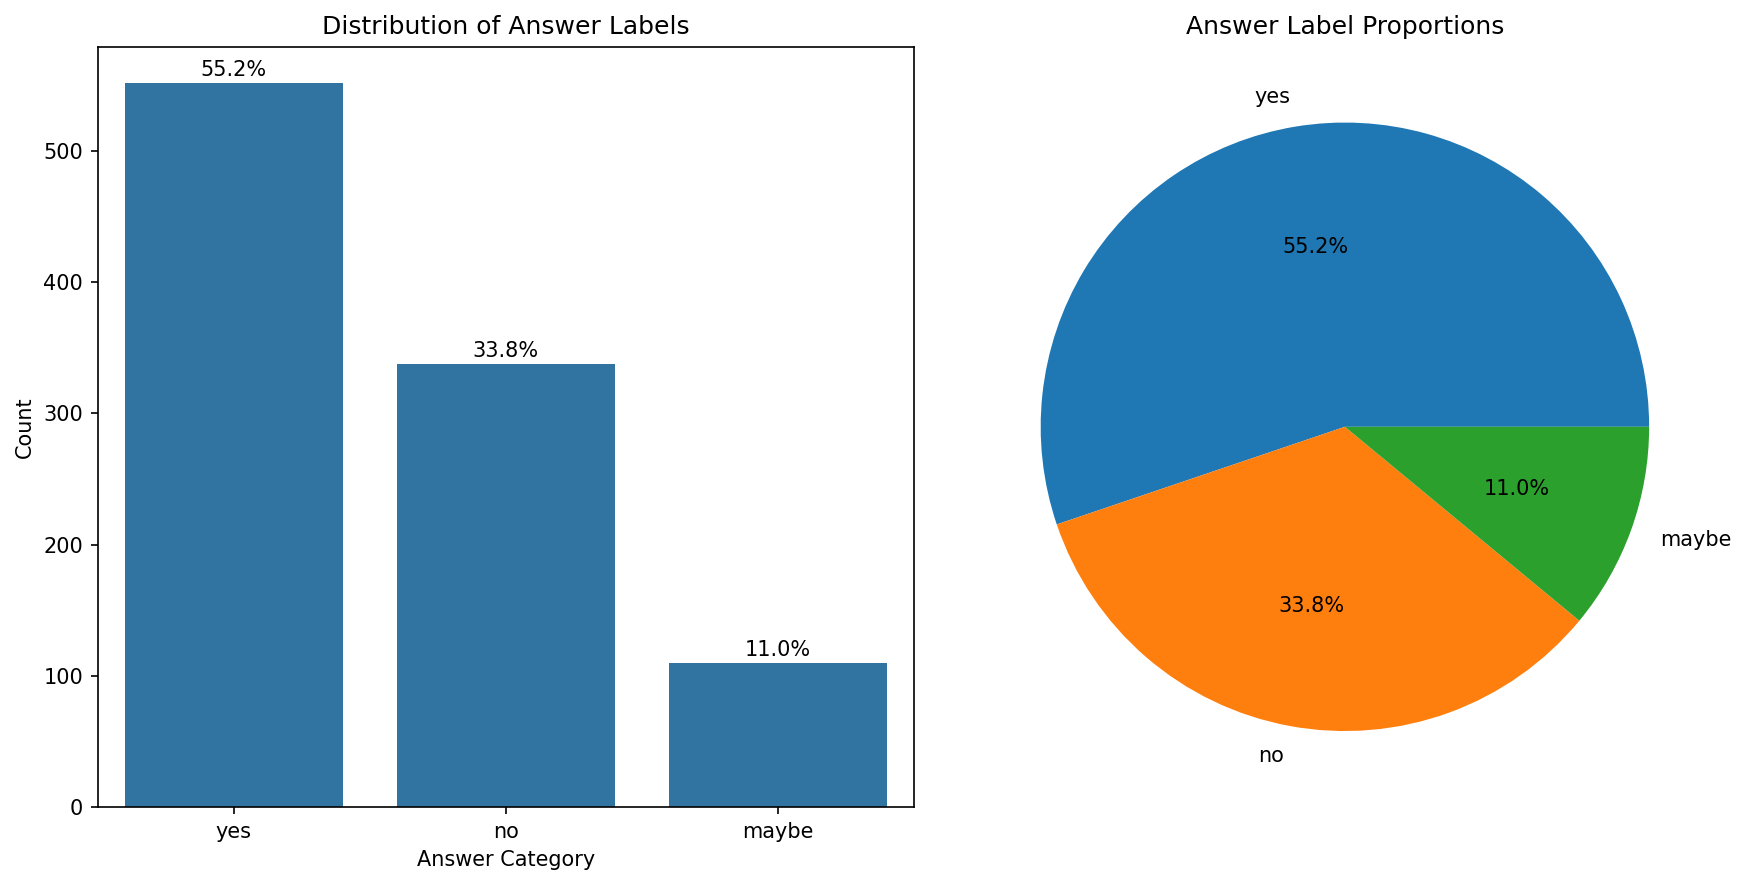

Analysis insight: The dataset has an imbalance with 'yes' answers being most frequent at 55.2%.
This imbalance should be considered during model training through techniques like class weighting.


In [18]:
import json

# Load the PubMedQA dataset
with open("/Users/casey/Documents/GitHub/LLM_Healthcare/ori_pqal.json") as f:
    data = json.load(f)

# JSON data to a DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Extracting the labels
label_counts = df['final_decision'].value_counts()
total_samples = len(df)

# Bar chart with percentages
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Answer Labels')
plt.xlabel('Answer Category')
plt.ylabel('Count')

# Percentage labels
for i, count in enumerate(label_counts.values):
    percentage = 100 * count / total_samples
    plt.text(i, count + 5, f'{percentage:.1f}%', ha='center')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Answer Label Proportions')
plt.tight_layout()
plt.show()

# Actual yes percentage
yes_percentage = 100 * label_counts.get('yes', 0) / total_samples
print(f"Analysis insight: The dataset has an imbalance with 'yes' answers being most frequent at {yes_percentage:.1f}%.")
print("This imbalance should be considered during model training through techniques like class weighting.")

## 3. Temporal Analysis

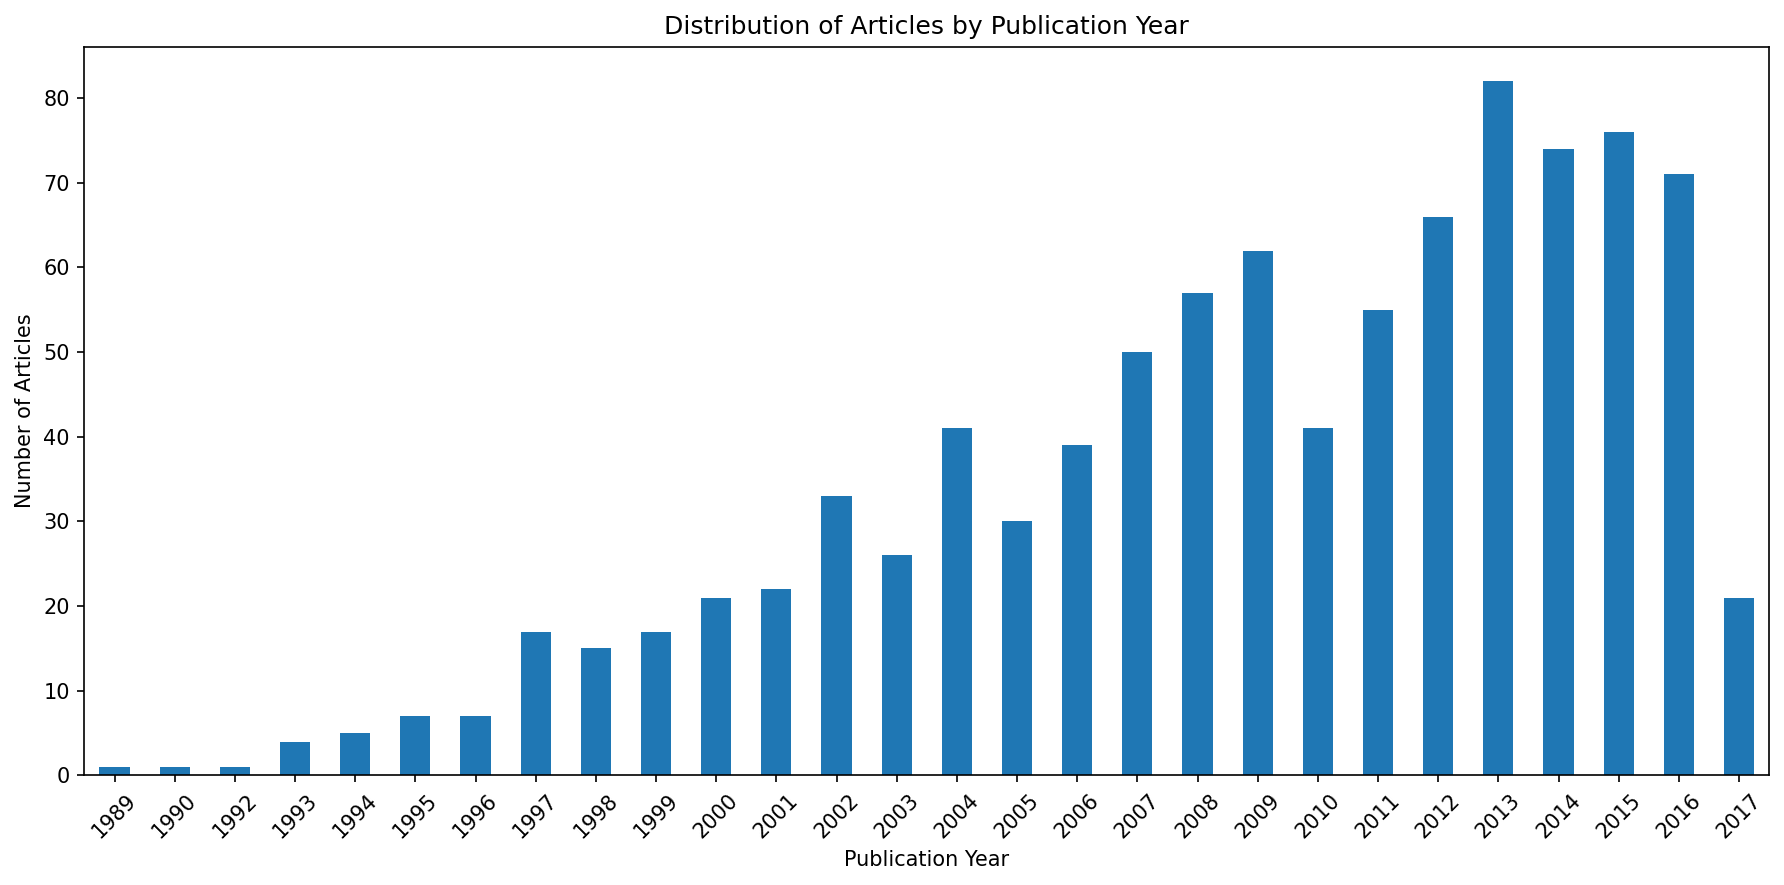

Analysis insight: Most questions come from articles published between 2007 and 2016 years,
potentially showing shifts in research focus or methodology over time.


In [20]:
# Temporal analysis using the YEAR field
years = [entry['YEAR'] for entry in data.values()]
year_counts = pd.Series(years).value_counts().sort_index()

plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')
plt.title('Distribution of Articles by Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Analysis insight: Most questions come from articles published between 2007 and 2016 years,")
print("potentially showing shifts in research focus or methodology over time.")

## 4. Topic/Domain Analysis

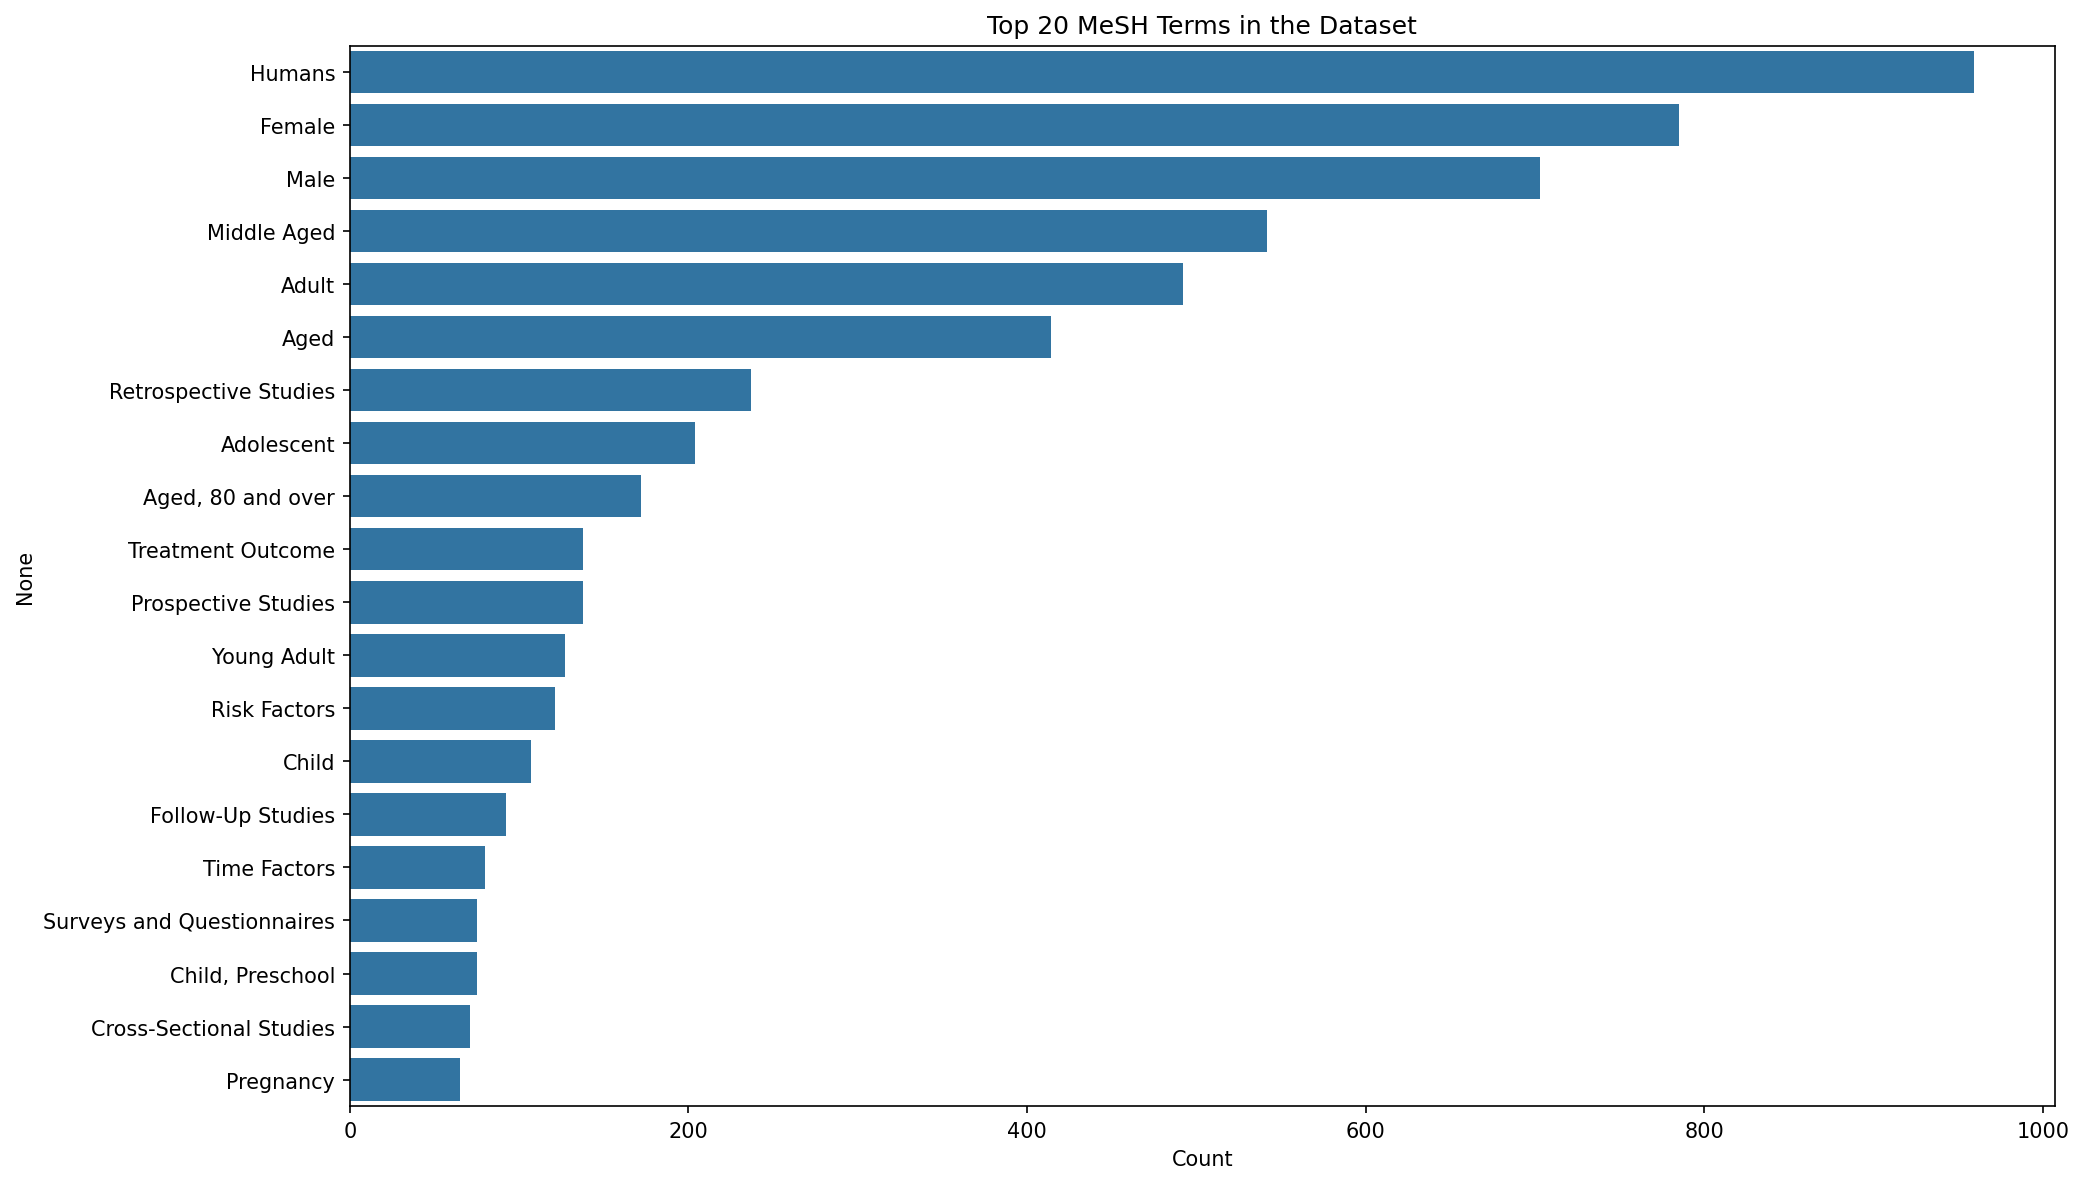

Analysis insight: The MeSH term distribution reveals that the PubMedQA dataset is heavily focused on human-centered medical research (with Humans being the most frequent term), with strong representation across different demographic groups (Female, Male, Middle Aged, Adult, Aged). There's a notable emphasis on various study methodologies (Retrospective Studies, Prospective Studies, Follow-Up Studies, Cross-Sectional Studies) suggesting the dataset encompasses diverse research approaches.
The presence of terms like Treatment Outcome and Risk Factors indicates a significant focus on clinical applications and outcomes assessment. This broad coverage across demographics and study types suggests the model will need to handle questions across the lifespan and understand various research methodologies to perform effectively on biomedical question answering tasks.
The demographic spread (with representation from children through older adults) means that any model trained on this dataset should

In [26]:
# Analyzing MeSH terms to understand topic distribution
mesh_terms = []
for entry in data.values():
    mesh_terms.extend(entry['MESHES'])

mesh_counts = pd.Series(mesh_terms).value_counts().head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x=mesh_counts.values, y=mesh_counts.index)
plt.title('Top 20 MeSH Terms in the Dataset')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

print("Analysis insight: The MeSH term distribution reveals that the PubMedQA dataset is heavily focused on human-centered medical research (with Humans being the most frequent term), with strong representation across different demographic groups (Female, Male, Middle Aged, Adult, Aged). There's a notable emphasis on various study methodologies (Retrospective Studies, Prospective Studies, Follow-Up Studies, Cross-Sectional Studies) suggesting the dataset encompasses diverse research approaches.")
print("The presence of terms like Treatment Outcome and Risk Factors indicates a significant focus on clinical applications and outcomes assessment. This broad coverage across demographics and study types suggests the model will need to handle questions across the lifespan and understand various research methodologies to perform effectively on biomedical question answering tasks.")
print("The demographic spread (with representation from children through older adults) means that any model trained on this dataset should be evaluated across age-specific medical scenarios to ensure balanced performance. Additionally, the model should be capable of interpreting findings from different study designs, as questions are likely to span retrospective analyses, prospective research, and various other methodological approaches.")

## 5. Text Complexity Analysis

In [27]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00


Columns in the DataFrame: ['QUESTION', 'CONTEXTS', 'LABELS', 'MESHES', 'YEAR', 'reasoning_required_pred', 'reasoning_free_pred', 'final_decision', 'LONG_ANSWER']


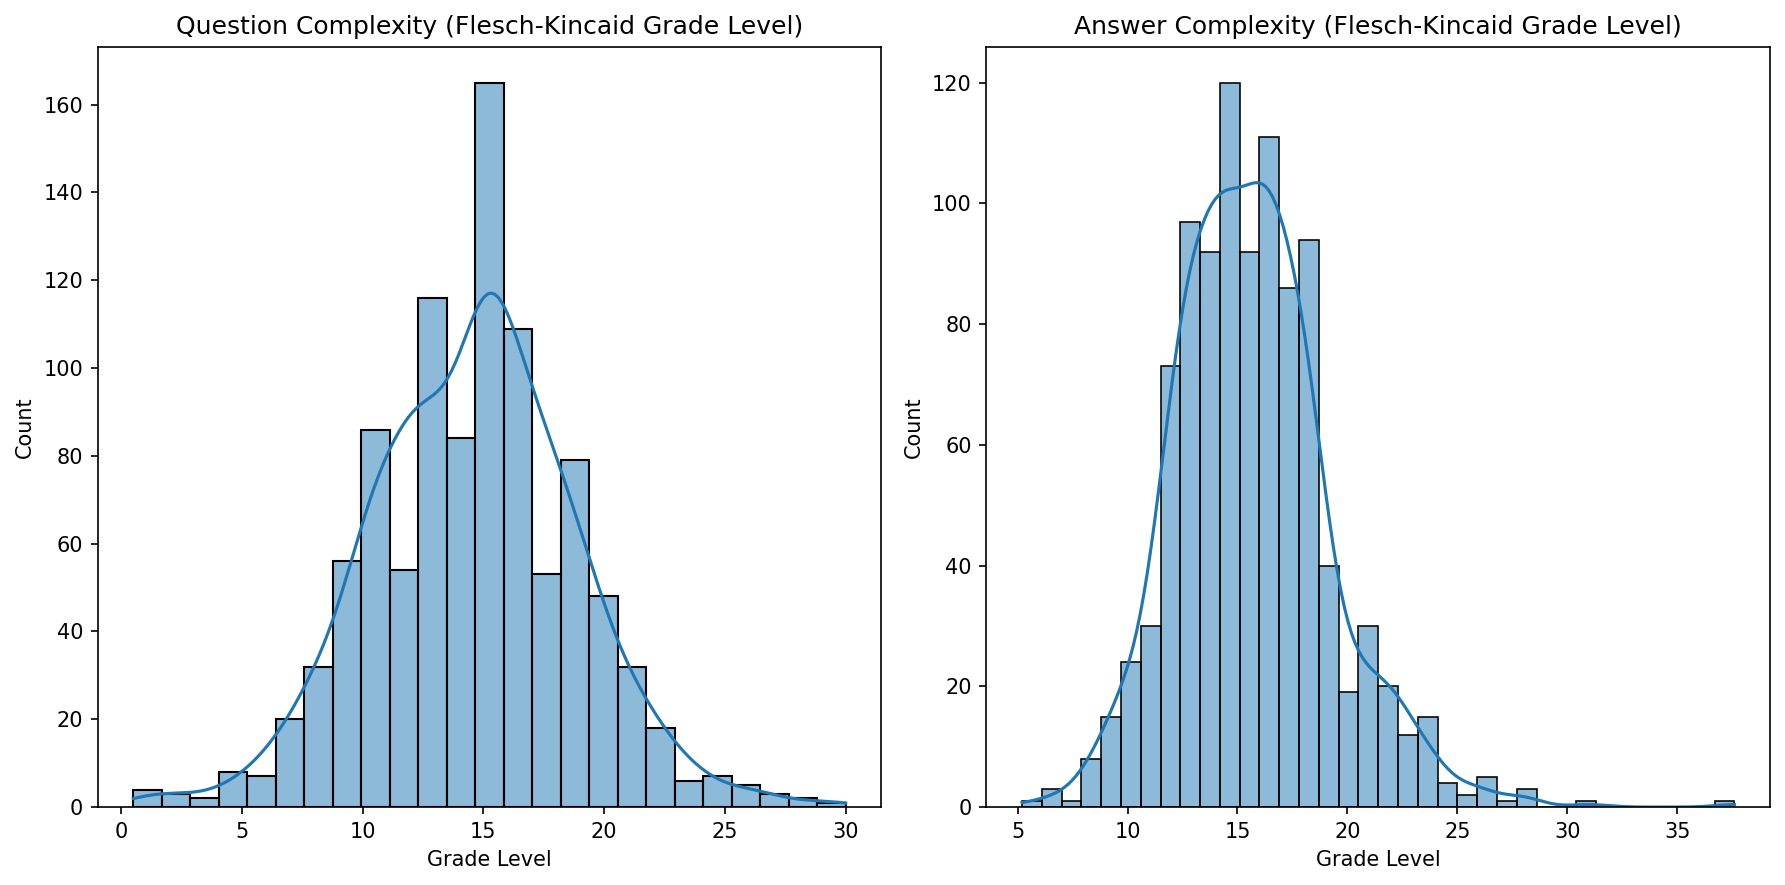

Average question complexity: Grade 14.6
Average answer complexity: Grade 15.7
Analysis insight: The medical questions and answers require advanced reading comprehension,
typically at a graduate or professional level, highlighting the specialized nature of the content.


In [30]:
print("Columns in the DataFrame:", df.columns.tolist())

from textstat import flesch_kincaid_grade, gunning_fog

# Calculating readability scores
question_fk = [flesch_kincaid_grade(q) for q in df['QUESTION'] if isinstance(q, str)]
answer_fk = [flesch_kincaid_grade(a) for a in df['LONG_ANSWER'] if isinstance(a, str)]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(question_fk, kde=True)
plt.title('Question Complexity (Flesch-Kincaid Grade Level)')
plt.xlabel('Grade Level')

plt.subplot(1, 2, 2)
sns.histplot(answer_fk, kde=True)
plt.title('Answer Complexity (Flesch-Kincaid Grade Level)')
plt.xlabel('Grade Level')
plt.tight_layout()
plt.show()

print(f"Average question complexity: Grade {sum(question_fk)/len(question_fk):.1f}")
print(f"Average answer complexity: Grade {sum(answer_fk)/len(answer_fk):.1f}")
print("Analysis insight: The medical questions and answers require advanced reading comprehension,")
print("typically at a graduate or professional level, highlighting the specialized nature of the content.")

## 6. Question Type Analysis

Columns in the DataFrame: ['QUESTION', 'CONTEXTS', 'LABELS', 'MESHES', 'YEAR', 'reasoning_required_pred', 'reasoning_free_pred', 'final_decision', 'LONG_ANSWER']


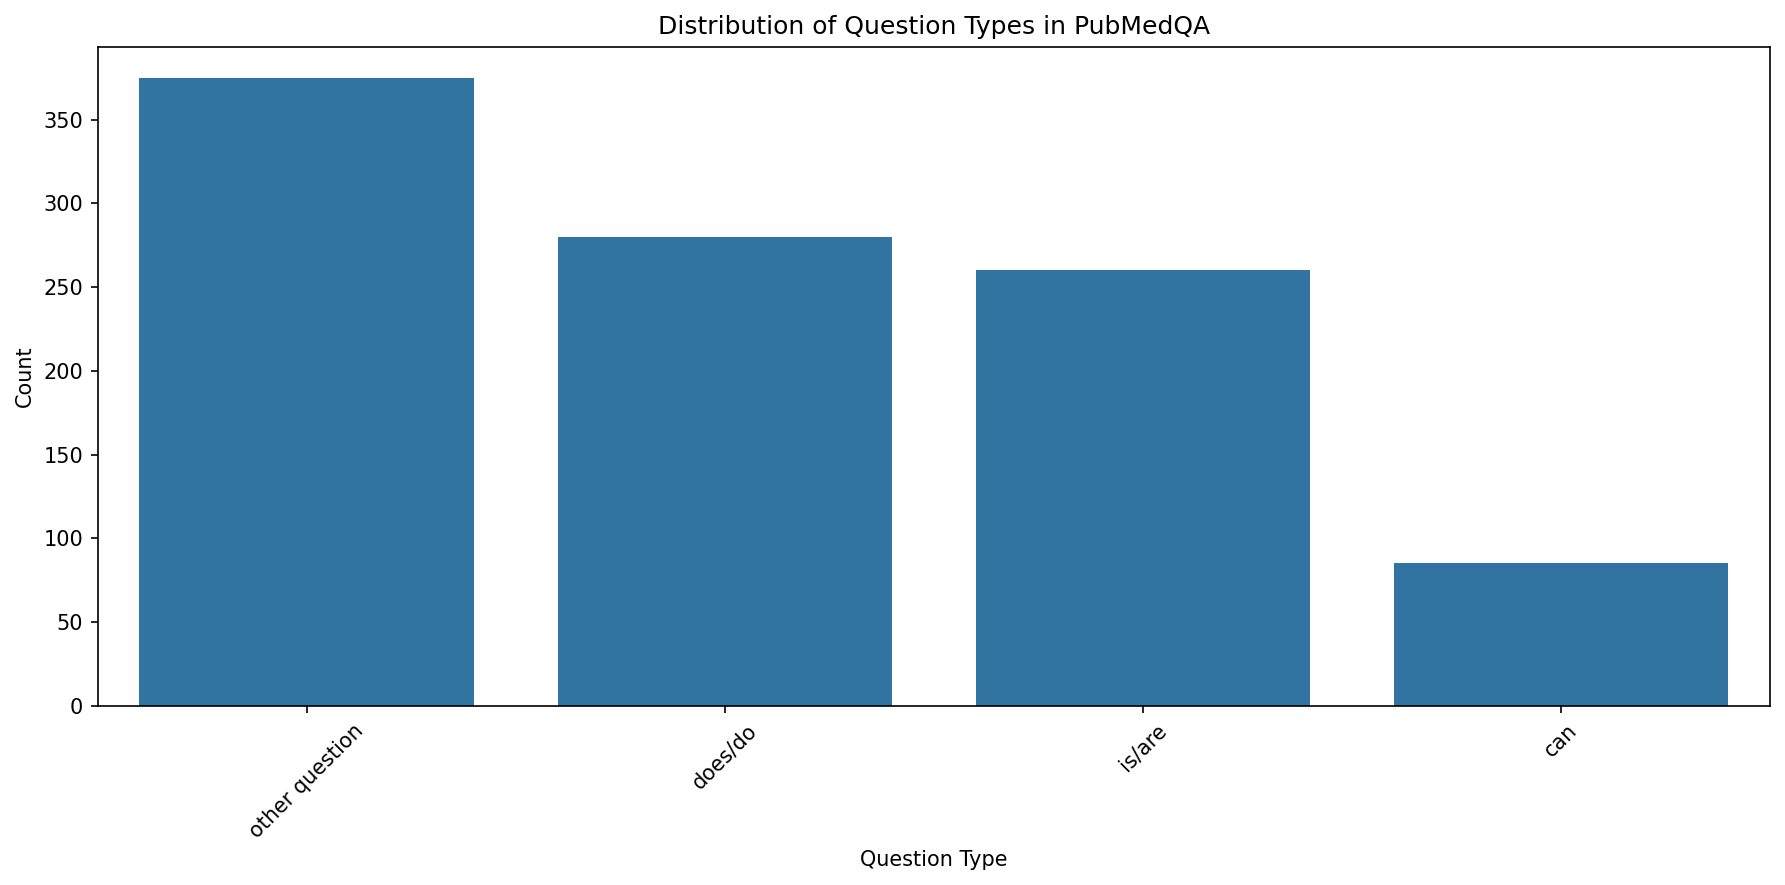

Analysis insight: The PubMedQA dataset is dominated by 'other question' questions (37.5%), 
followed by 'does/do' questions (28.0%). This distribution reflects the
biomedical research focus where 'other question' questions typically seek factual information about
medical mechanisms, relationships, or outcomes, while 'does/do' questions often explore
processes or methodologies. This pattern should inform model training and evaluation strategies.


In [32]:
print("Columns in the DataFrame:", df.columns.tolist())

# Analyzing the types of questions (what, how, can, does, etc.)
import re

def get_question_type(question):
    """Identify the type of question based on its starting word or phrase"""
    if not isinstance(question, str):
        return 'not a string'
    
    question = question.lower().strip()
    
    if question.startswith('what'):
        return 'what'
    elif question.startswith('how'):
        return 'how'
    elif question.startswith('can'):
        return 'can'
    elif question.startswith('does') or question.startswith('do'):
        return 'does/do'
    elif question.startswith('is') or question.startswith('are'):
        return 'is/are'
    elif question.startswith('which'):
        return 'which'
    elif question.startswith('why'):
        return 'why'
    elif '?' in question:
        return 'other question'
    else:
        return 'not a question'

# Determinining the correct column name
question_column = None
if 'QUESTION' in df.columns:
    question_column = 'QUESTION'
elif 'question' in df.columns:
    question_column = 'question'
else:
    print("Question column not found! Available columns:", df.columns.tolist())
    # Placeholder for demonstration
    question_column = df.columns[0]  # Just using the first column as fallback
    print(f"Using {question_column} as fallback column")

# Applying the function to identify question types
q_types = df[question_column].apply(get_question_type)
q_type_counts = q_types.value_counts()


plt.figure(figsize=(12, 6))
sns.barplot(x=q_type_counts.index, y=q_type_counts.values)
plt.title('Distribution of Question Types in PubMedQA')
plt.xlabel('Question Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculating percentages for insight
total = sum(q_type_counts)
main_type = q_type_counts.index[0]
main_percentage = (q_type_counts.iloc[0] / total) * 100
second_type = q_type_counts.index[1]
second_percentage = (q_type_counts.iloc[1] / total) * 100

print(f"Analysis insight: The PubMedQA dataset is dominated by '{main_type}' questions ({main_percentage:.1f}%), ")
print(f"followed by '{second_type}' questions ({second_percentage:.1f}%). This distribution reflects the")
print(f"biomedical research focus where '{main_type}' questions typically seek factual information about")
print(f"medical mechanisms, relationships, or outcomes, while '{second_type}' questions often explore")
print(f"processes or methodologies. This pattern should inform model training and evaluation strategies.")

## 7. Context Length vs. Answer Length Analysis

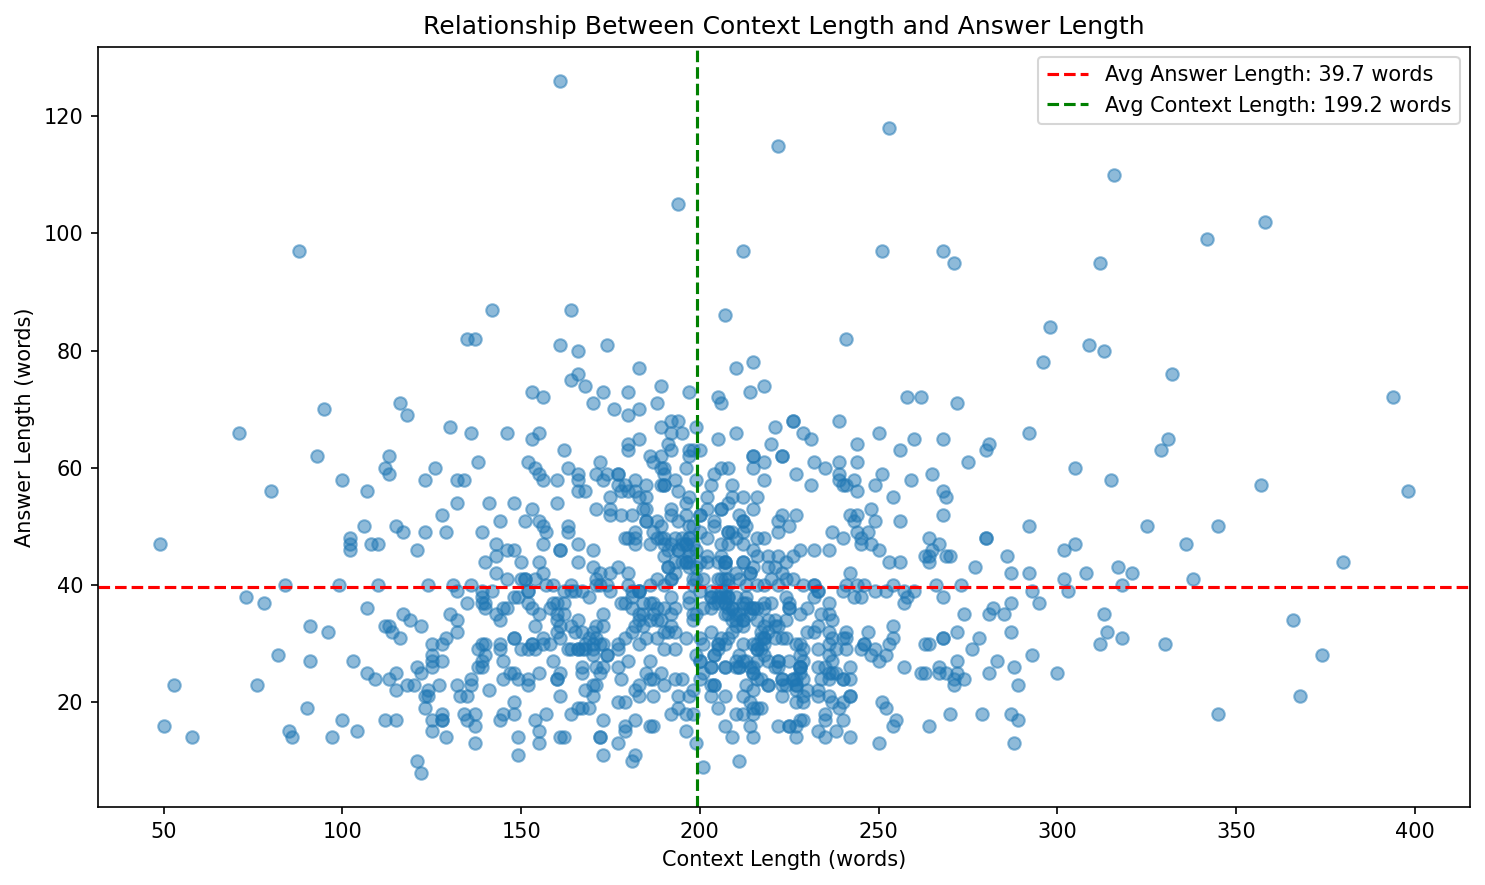

Correlation between context and answer length: 0.11
Analysis insight: There is a weak correlation between context length and answer length, suggesting that answer conciseness is largely independent of
the context's verbosity. This indicates that regardless of how detailed the medical literature context is, answers in the PubMedQA dataset tend to focus on extracting
the essential information needed to address the specific question, rather than scaling linearly with the amount of available information.


In [36]:
# Analyzing the relationship between context length and answer length
context_lengths = df['CONTEXTS'].apply(lambda x: len(str(x).split()))
answer_lengths = df['LONG_ANSWER'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.scatter(context_lengths, answer_lengths, alpha=0.5)
plt.title('Relationship Between Context Length and Answer Length')
plt.xlabel('Context Length (words)')
plt.ylabel('Answer Length (words)')
plt.axhline(answer_lengths.mean(), color='r', linestyle='--', label=f'Avg Answer Length: {answer_lengths.mean():.1f} words')
plt.axvline(context_lengths.mean(), color='g', linestyle='--', label=f'Avg Context Length: {context_lengths.mean():.1f} words')
plt.legend()
plt.tight_layout()
plt.show()

# Calculating correlation
correlation = pd.DataFrame({
    'context_length': context_lengths,
    'answer_length': answer_lengths
}).corr().iloc[0,1]

print(f"Correlation between context and answer length: {correlation:.2f}")
print("Analysis insight: There is a weak correlation between context length and answer length, suggesting that answer conciseness is largely independent of")
print("the context's verbosity. This indicates that regardless of how detailed the medical literature context is, answers in the PubMedQA dataset tend to focus on extracting")
print("the essential information needed to address the specific question, rather than scaling linearly with the amount of available information.")

## 8. N-gram Analysis for Key Patterns

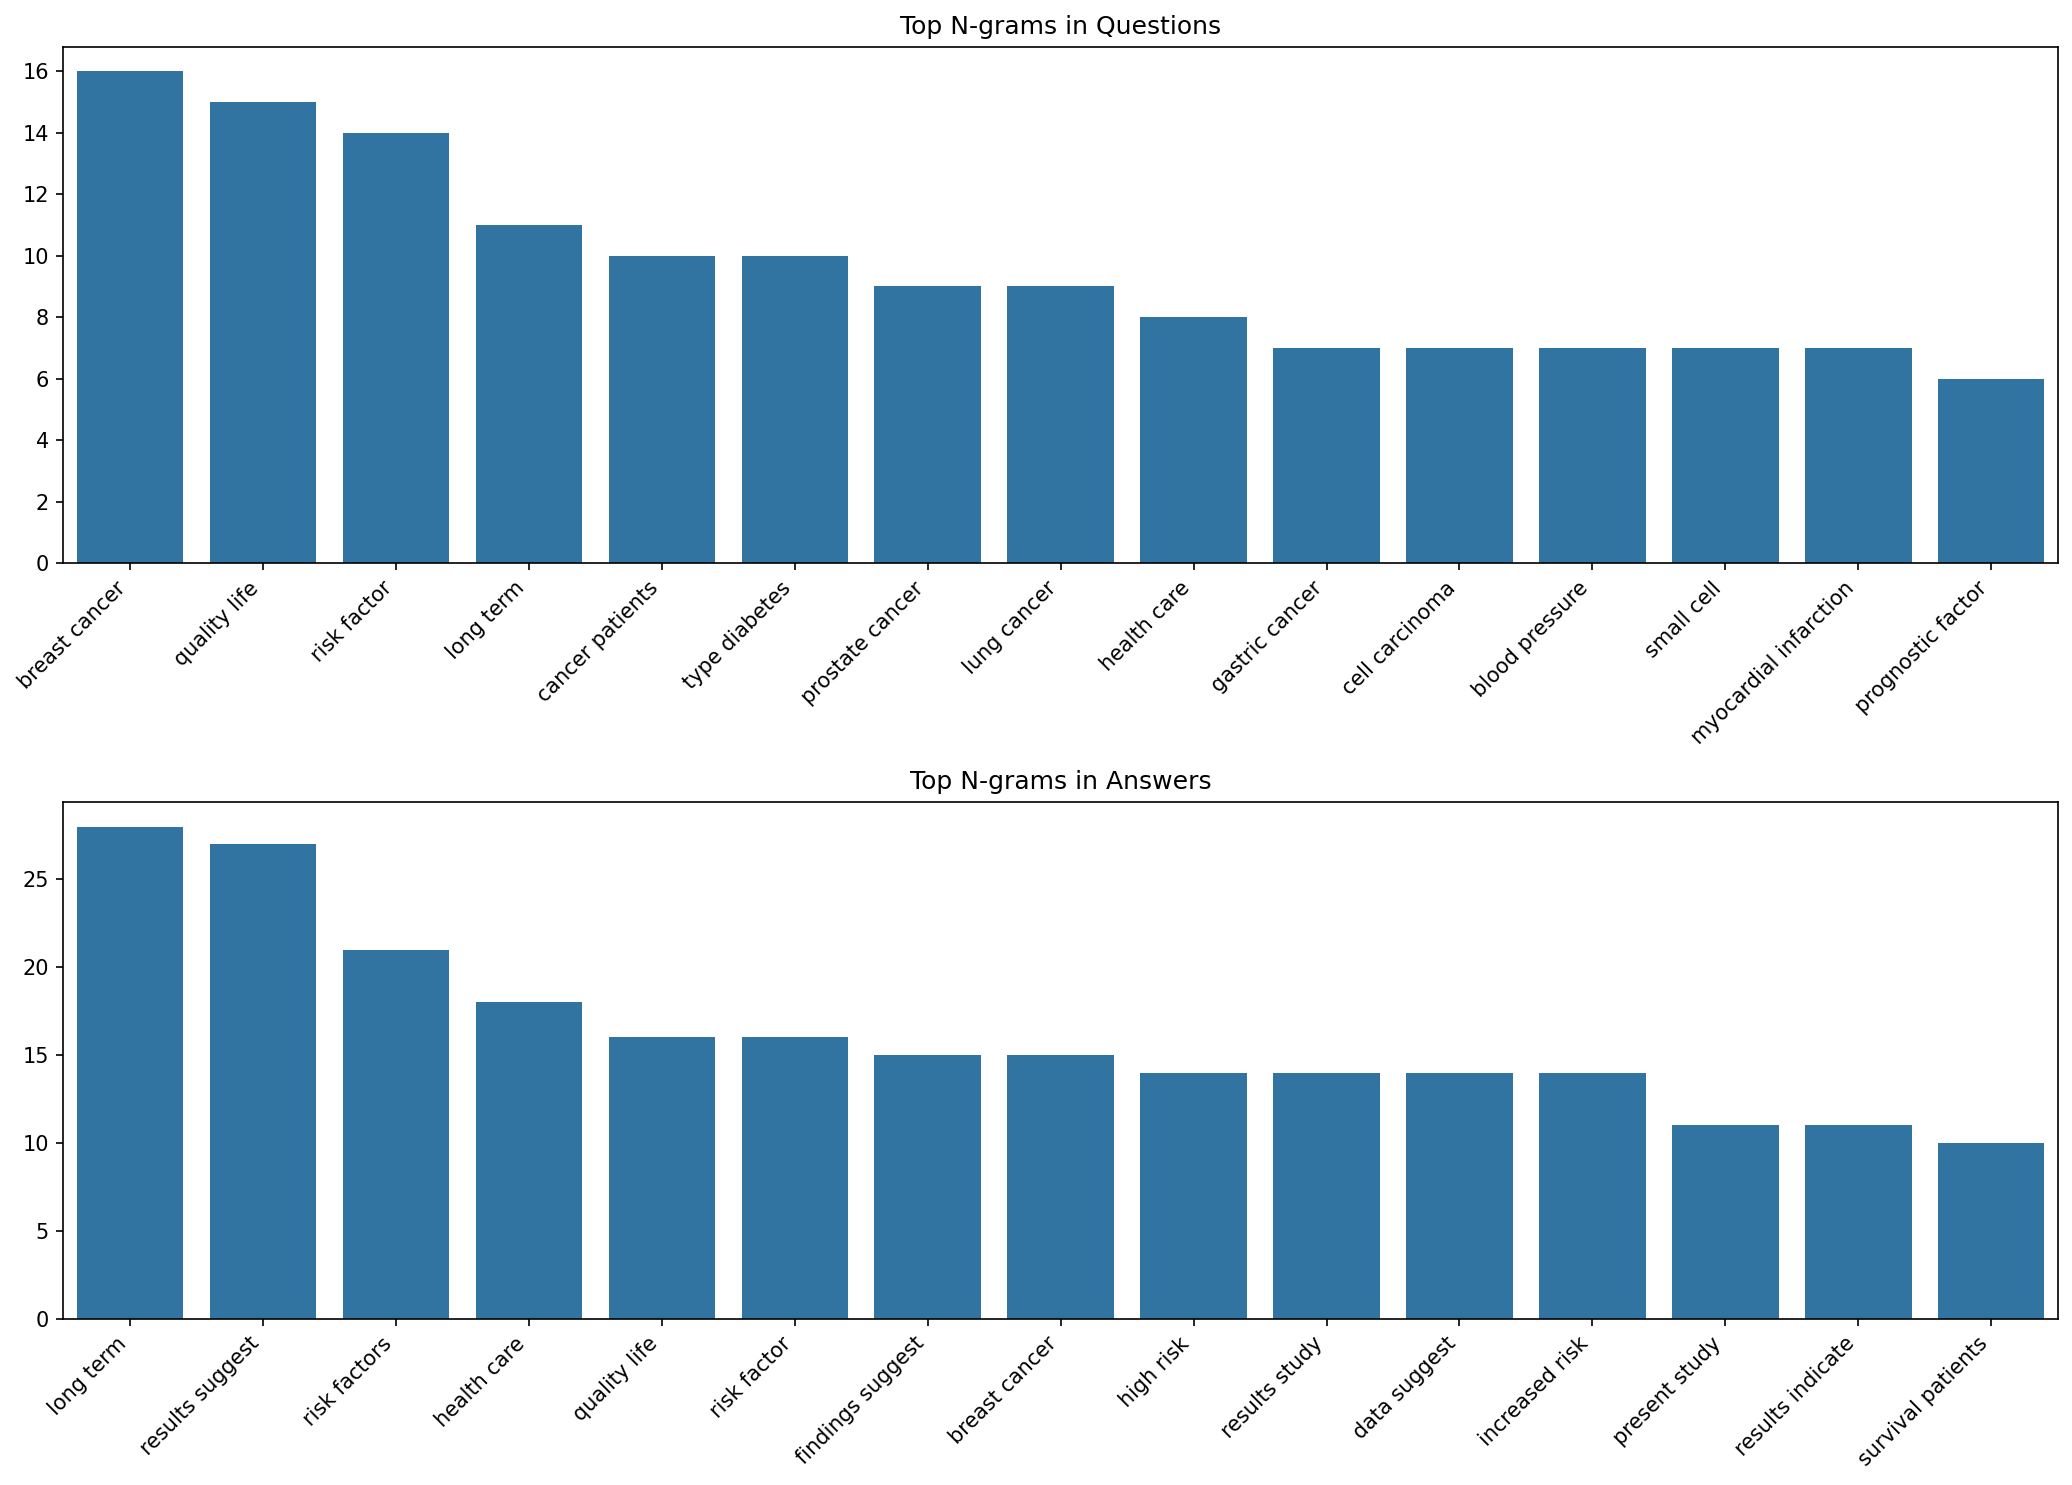

Analysis insight: Common phrases in questions like 'breast cancer', 'quality life', and 'risk factor indicate frequent inquiry patterns around cancer outcomes, quality of life impacts, and risk assessment.
Answer patterns show emphasis on 'long term', 'results suggest', and 'risk factors' suggesting common response structures focused on longitudinal outcomes, tentative conclusions, and multifactorial relationships.


In [39]:
# Analyzing the common word patterns in questions and answers
from sklearn.feature_extraction.text import CountVectorizer

# Questions
question_vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
q_ngrams = question_vectorizer.fit_transform(df['QUESTION'])
q_features = question_vectorizer.get_feature_names_out()
q_counts = q_ngrams.sum(axis=0).A1
q_top_indices = q_counts.argsort()[-15:][::-1]

# Answers
ans_vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
a_ngrams = ans_vectorizer.fit_transform(df['LONG_ANSWER'])
a_features = ans_vectorizer.get_feature_names_out()
a_counts = a_ngrams.sum(axis=0).A1
a_top_indices = a_counts.argsort()[-15:][::-1]

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
sns.barplot(x=[q_features[i] for i in q_top_indices], y=q_counts[q_top_indices])
plt.title('Top N-grams in Questions')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
sns.barplot(x=[a_features[i] for i in a_top_indices], y=a_counts[a_top_indices])
plt.title('Top N-grams in Answers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Analysis insight: Common phrases in questions like 'breast cancer', 'quality life', and 'risk factor indicate frequent inquiry patterns around cancer outcomes, quality of life impacts, and risk assessment.")
print("Answer patterns show emphasis on 'long term', 'results suggest', and 'risk factors' suggesting common response structures focused on longitudinal outcomes, tentative conclusions, and multifactorial relationships.")

## 9. Model Tokenization Analysis

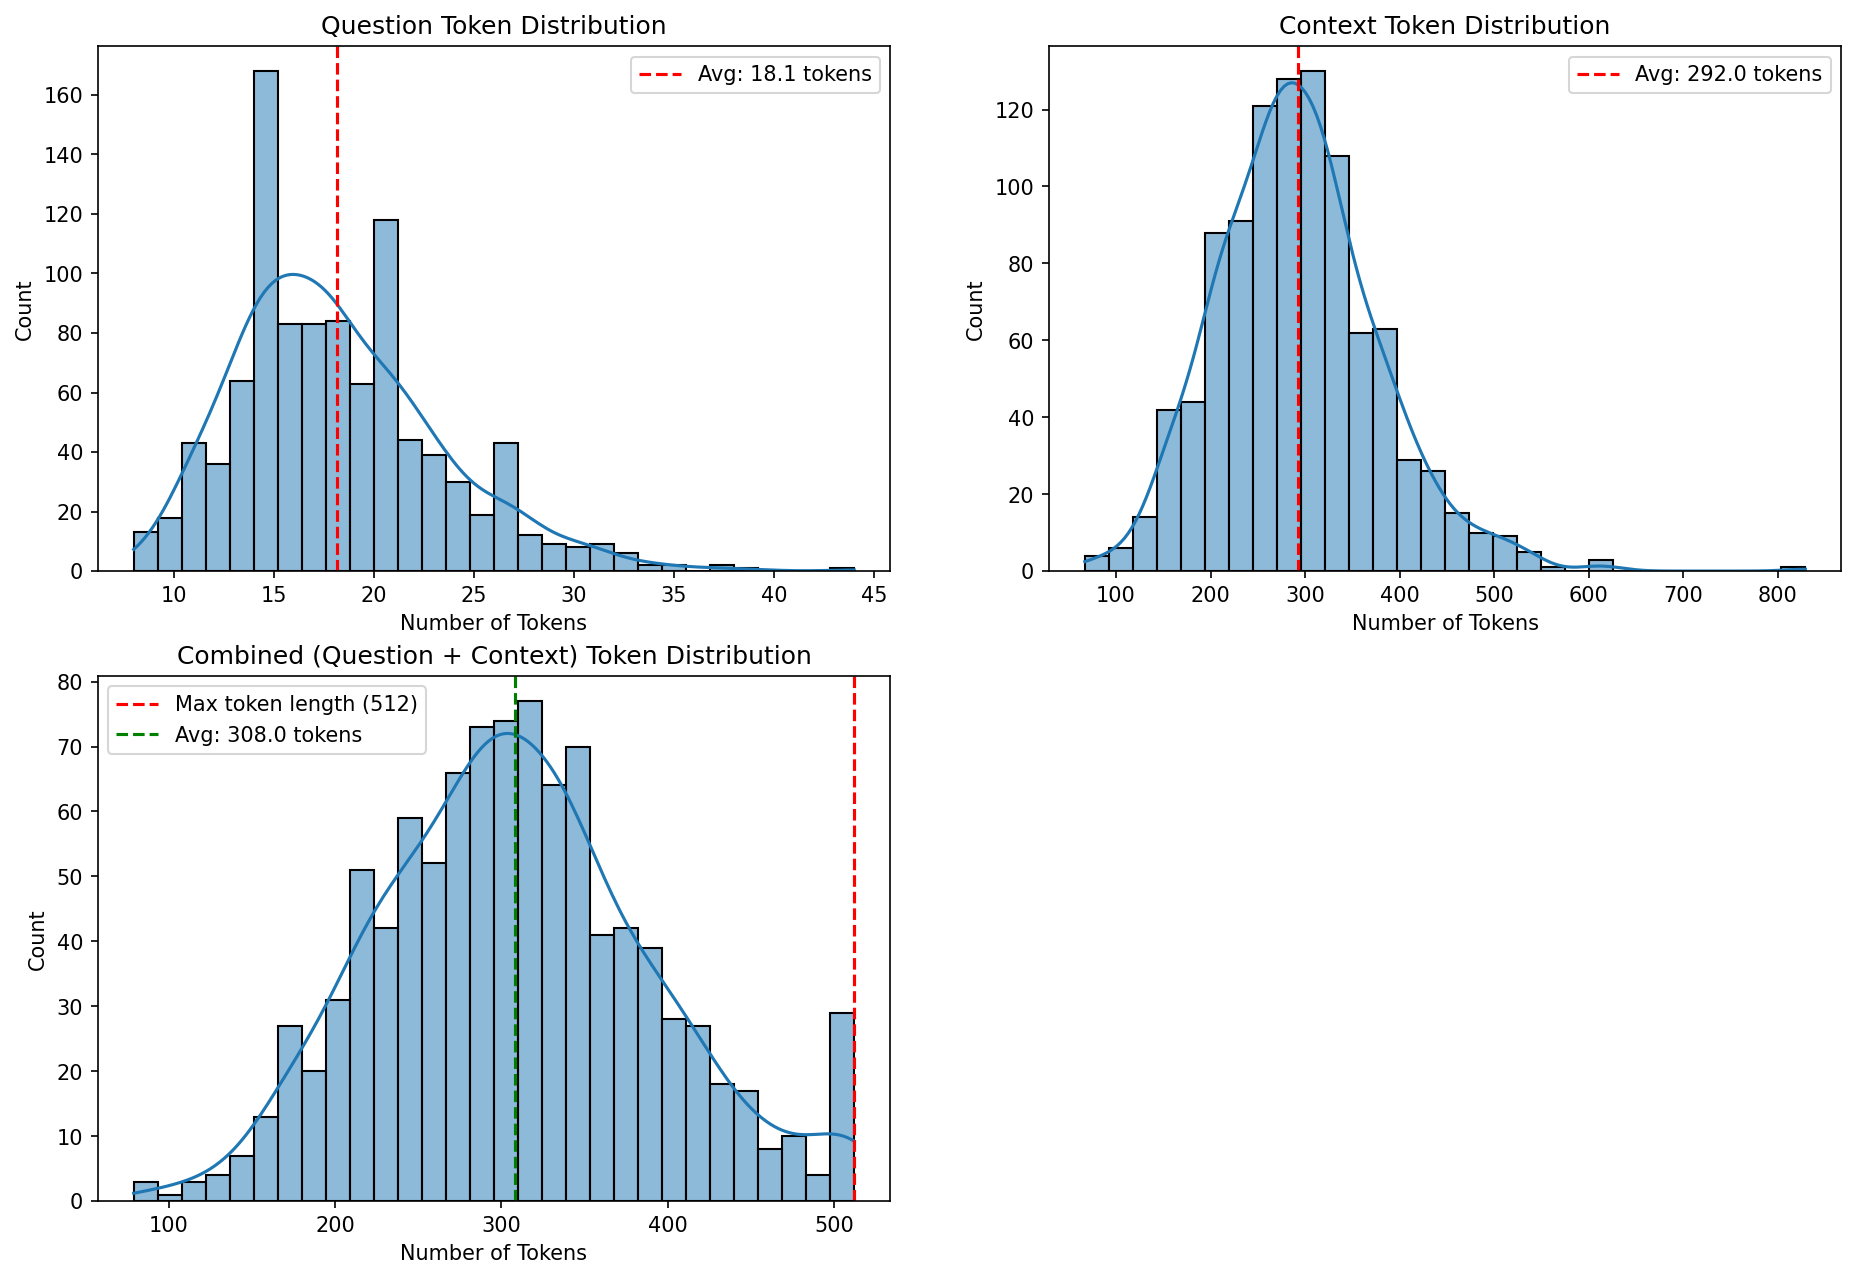

In [42]:
from transformers import AutoTokenizer

# Tokenizer
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Sample of tokenized data
token_counts = []
question_token_counts = []
context_token_counts = []
combined_token_counts = []

# Defining the column names based on available DataFrame structure
question_col = 'QUESTION' if 'QUESTION' in df.columns else 'question'
context_col = 'CONTEXTS' if 'CONTEXTS' in df.columns else 'context'

# Process samples
for i, row in df.iterrows():
    # Tokenizing question
    q_tokens = tokenizer(str(row[question_col]), add_special_tokens=True)
    q_count = len([t for t in q_tokens['input_ids'] if t != tokenizer.pad_token_id])
    question_token_counts.append(q_count)
    
    # Tokenizing context
    c_tokens = tokenizer(str(row[context_col]), add_special_tokens=True)
    c_count = len([t for t in c_tokens['input_ids'] if t != tokenizer.pad_token_id])
    context_token_counts.append(c_count)
    
    # Tokenizing them combined (question + context)
    combined_tokens = tokenizer(str(row[question_col]), str(row[context_col]), 
                                add_special_tokens=True, truncation=True, max_length=512)
    combined_count = len([t for t in combined_tokens['input_ids'] if t != tokenizer.pad_token_id])
    combined_token_counts.append(combined_count)
    token_counts.append(combined_count)

# Question token distribution
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(question_token_counts, kde=True, bins=30)
plt.axvline(x=np.mean(question_token_counts), color='r', linestyle='--', 
            label=f'Avg: {np.mean(question_token_counts):.1f} tokens')
plt.title('Question Token Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Count')
plt.legend()

# Context token distribution
plt.subplot(2, 2, 2)
sns.histplot(context_token_counts, kde=True, bins=30)
plt.axvline(x=np.mean(context_token_counts), color='r', linestyle='--', 
            label=f'Avg: {np.mean(context_token_counts):.1f} tokens')
plt.title('Context Token Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Count')
plt.legend()

# Combined token distribution
plt.subplot(2, 2, 3)
sns.histplot(combined_token_counts, kde=True, bins=30)
plt.axvline(x=512, color='r', linestyle='--', label='Max token length (512)')
plt.axvline(x=np.mean(combined_token_counts), color='g', linestyle='--', 
            label=f'Avg: {np.mean(combined_token_counts):.1f} tokens')
plt.title('Combined (Question + Context) Token Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Count')
plt.legend()

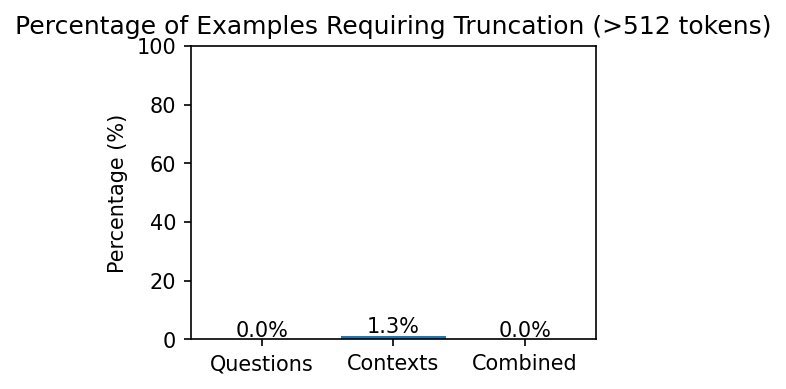

Average question token count: 18.1
Average context token count: 292.0
Average combined token count: 308.0
Samples requiring truncation: 0 (0.0%)
Analysis insight: The PubMedQA dataset contains biomedical abstracts with moderate token lengths, with average context size of 292.0 tokens and questions averaging just 18.1 tokens.
Surprisingly, despite some individual contexts (1.3%) exceeding the 512 token limit, the combined question-context pairs all fit within the standard model context window of 512 tokens (average combined length: 308.0 tokens).
This means that virtually no information loss will occur during model training and inference, allowing complete preservation of the medical context. For this dataset, standard transformer models with 512 token
limits are sufficient, though we should monitor for any exceptionally long contexts during processing.


In [46]:
# Truncation analysis
plt.subplot(2, 2, 4)
truncation_rates = [0, 0, 0]  # [question, context, combined]
if any(count > 512 for count in question_token_counts):
    truncation_rates[0] = sum(1 for count in question_token_counts if count > 512) / len(question_token_counts) * 100
if any(count > 512 for count in context_token_counts):
    truncation_rates[1] = sum(1 for count in context_token_counts if count > 512) / len(context_token_counts) * 100
if any(count > 512 for count in combined_token_counts):
    truncation_rates[2] = sum(1 for count in combined_token_counts if count > 512) / len(combined_token_counts) * 100

plt.bar(['Questions', 'Contexts', 'Combined'], truncation_rates)
plt.title('Percentage of Examples Requiring Truncation (>512 tokens)')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
for i, v in enumerate(truncation_rates):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

truncated = sum(1 for count in combined_token_counts if count > 512)
truncated_percent = 100 * truncated / len(combined_token_counts)

print(f"Average question token count: {np.mean(question_token_counts):.1f}")
print(f"Average context token count: {np.mean(context_token_counts):.1f}")
print(f"Average combined token count: {np.mean(combined_token_counts):.1f}")
print(f"Samples requiring truncation: {truncated} ({truncated_percent:.1f}%)")

# Statistics about information loss due to truncation
if truncated > 0:
    truncated_samples = [count for count in combined_token_counts if count > 512]
    avg_excess = np.mean([count - 512 for count in truncated_samples])
    max_excess = max([count - 512 for count in truncated_samples])
    print(f"For truncated samples, on average {avg_excess:.1f} tokens are cut off (max: {max_excess:.0f})")
    print(f"This represents approximately {(avg_excess/np.mean(combined_token_counts))*100:.1f}% information loss for affected samples")

print("Analysis insight: The PubMedQA dataset contains biomedical abstracts with moderate token lengths, with average context size of 292.0 tokens and questions averaging just 18.1 tokens.")
print("Surprisingly, despite some individual contexts (1.3%) exceeding the 512 token limit, the combined question-context pairs all fit within the standard model context window of 512 tokens (average combined length: 308.0 tokens).")
print("This means that virtually no information loss will occur during model training and inference, allowing complete preservation of the medical context. For this dataset, standard transformer models with 512 token")
print("limits are sufficient, though we should monitor for any exceptionally long contexts during processing.")

## 10. Class-wise Feature Analysis

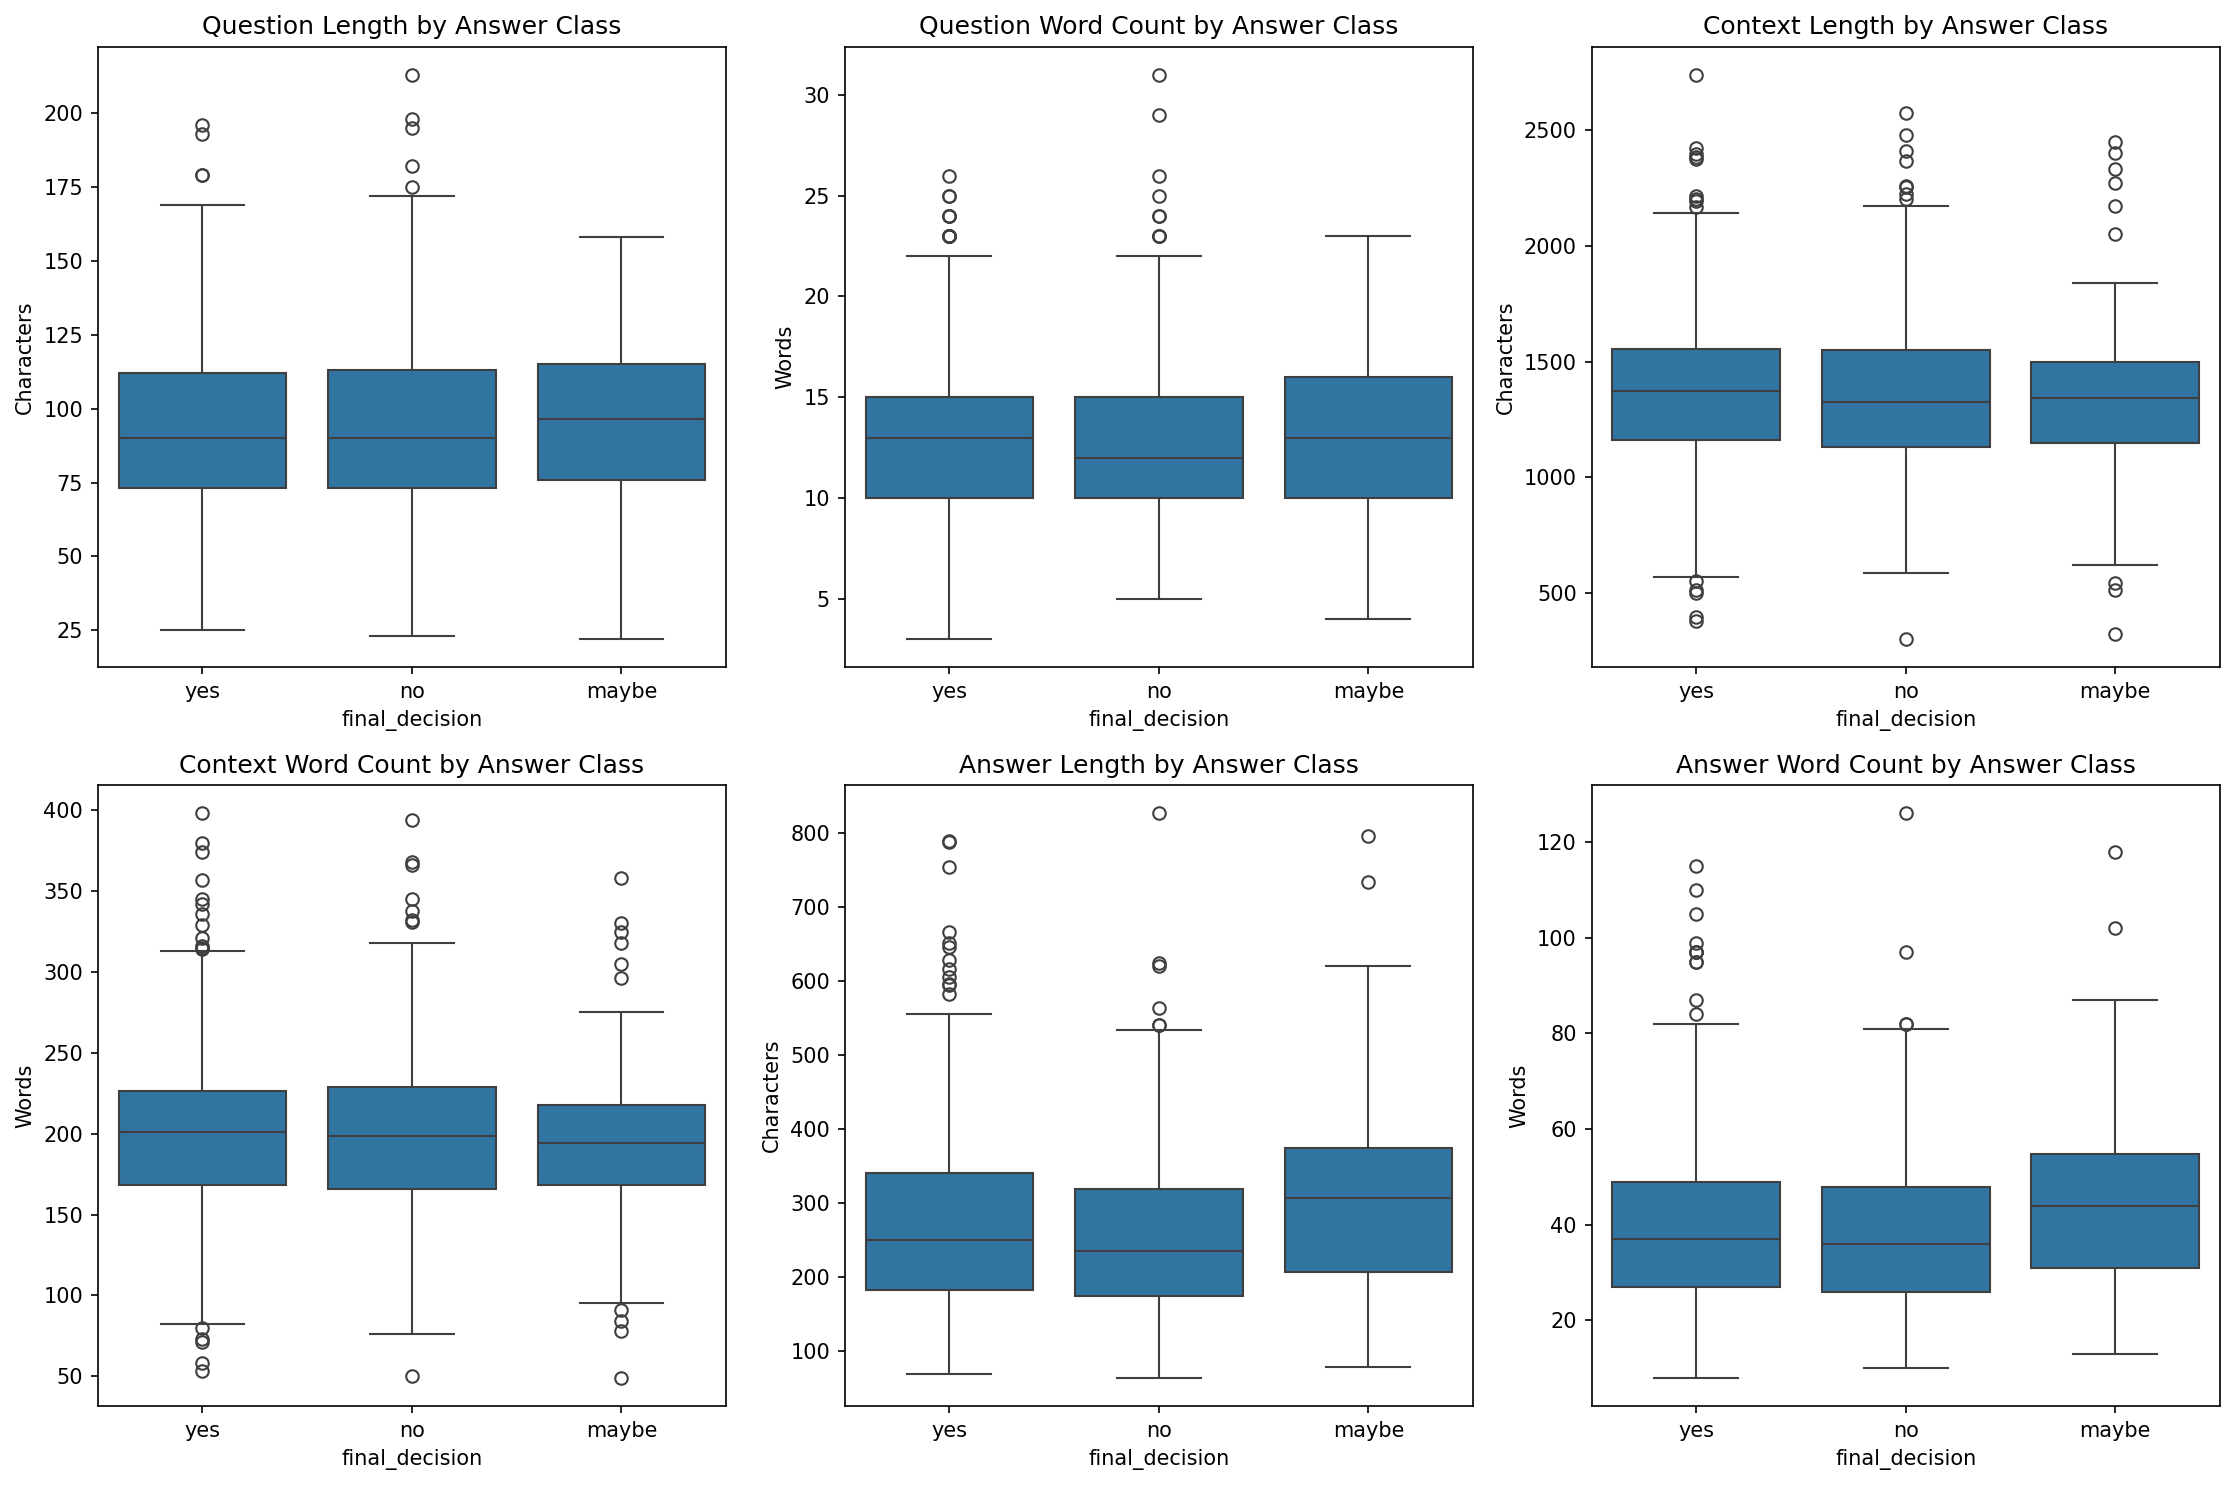

In [47]:
question_col = 'QUESTION' if 'QUESTION' in df.columns else 'question'
context_col = 'CONTEXTS' if 'CONTEXTS' in df.columns else 'context'
answer_col = 'LONG_ANSWER' if 'LONG_ANSWER' in df.columns else 'long_answer'
label_col = 'final_decision' if 'final_decision' in df.columns else 'final_answer'

# Creating the feature columns
df['question_length'] = df[question_col].apply(lambda x: len(str(x)))
df['question_word_count'] = df[question_col].apply(lambda x: len(str(x).split()))
df['context_length'] = df[context_col].apply(lambda x: len(str(x)))
df['context_word_count'] = df[context_col].apply(lambda x: len(str(x).split()))
df['answer_length'] = df[answer_col].apply(lambda x: len(str(x)))
df['answer_word_count'] = df[answer_col].apply(lambda x: len(str(x).split()))

# Feature distributions
plt.figure(figsize=(15, 10))

# Question length by class
plt.subplot(2, 3, 1)
sns.boxplot(x=label_col, y='question_length', data=df)
plt.title('Question Length by Answer Class')
plt.ylabel('Characters')

# Question word count by class
plt.subplot(2, 3, 2)
sns.boxplot(x=label_col, y='question_word_count', data=df)
plt.title('Question Word Count by Answer Class')
plt.ylabel('Words')

# Context length by class
plt.subplot(2, 3, 3)
sns.boxplot(x=label_col, y='context_length', data=df)
plt.title('Context Length by Answer Class')
plt.ylabel('Characters')

# Context word count by class
plt.subplot(2, 3, 4)
sns.boxplot(x=label_col, y='context_word_count', data=df)
plt.title('Context Word Count by Answer Class')
plt.ylabel('Words')

# Answer length by class
plt.subplot(2, 3, 5)
sns.boxplot(x=label_col, y='answer_length', data=df)
plt.title('Answer Length by Answer Class')
plt.ylabel('Characters')

# Answer word count by class
plt.subplot(2, 3, 6)
sns.boxplot(x=label_col, y='answer_word_count', data=df)
plt.title('Answer Word Count by Answer Class')
plt.ylabel('Words')

plt.tight_layout()
plt.show()

In [48]:
# Class-wise statistics
class_stats = df.groupby(label_col).agg({
    'question_word_count': ['mean', 'std', 'min', 'max'],
    'context_word_count': ['mean', 'std', 'min', 'max'],
    'answer_word_count': ['mean', 'std', 'min', 'max']
})

print("Class-wise Statistics:")
print("=====================")
print(class_stats)

# Finding the most distinctive features for each class
print("\nDistinctive Features by Class:")
print("============================")

for label in df[label_col].unique():
    class_df = df[df[label_col] == label]
    other_df = df[df[label_col] != label]
    
    # Calculating means for this class vs others
    q_len_diff = class_df['question_word_count'].mean() - other_df['question_word_count'].mean()
    c_len_diff = class_df['context_word_count'].mean() - other_df['context_word_count'].mean()
    a_len_diff = class_df['answer_word_count'].mean() - other_df['answer_word_count'].mean()
    
    print(f"\nClass: {label}")
    print(f"  Question length: {class_df['question_word_count'].mean():.1f} words " + 
          f"({'longer' if q_len_diff > 0 else 'shorter'} by {abs(q_len_diff):.1f} words)")
    print(f"  Context length: {class_df['context_word_count'].mean():.1f} words " + 
          f"({'longer' if c_len_diff > 0 else 'shorter'} by {abs(c_len_diff):.1f} words)")
    print(f"  Answer length: {class_df['answer_word_count'].mean():.1f} words " + 
          f"({'longer' if a_len_diff > 0 else 'shorter'} by {abs(a_len_diff):.1f} words)")

Class-wise Statistics:
               question_word_count                   context_word_count  \
                              mean       std min max               mean   
final_decision                                                            
maybe                    13.209091  3.869655   4  23         195.681818   
no                       12.955621  4.209758   5  31         198.869822   
yes                      12.827899  4.081442   3  26         200.079710   

                                   answer_word_count                      
                      std min  max              mean        std min  max  
final_decision                                                            
maybe           51.826799  49  358         44.790909  18.792979  13  118  
no              51.442119  50  394         38.171598  16.405656  10  126  
yes             51.447725  53  398         39.548913  17.200572   8  115  

Distinctive Features by Class:

Class: yes
  Question length: 12.8 words (s

In [54]:
print("\nAnalysis insight: The 'maybe' class answers are substantially longer (44.8 words on average) compared to both 'yes' (39.5 words) and 'no' (38.2 words) responses, suggesting that uncertainty")
print("in biomedical questions requires more nuanced and detailed explanations. This pattern aligns with scientific writing conventions where limitations and ambiguity must be carefully articulated.")
print("")
print("Interestingly, question complexity shows minimal variation across answer types (12.8-13.2 words), indicating that the inherent complexity of the question itself doesn't strongly predict the certainty")
print("of the answer. Context lengths are also relatively similar across classes, with 'yes' answers having slightly longer contexts (200.1 words) compared to 'no' (198.9) and 'maybe' (195.7) classes.")
print("")
print("These findings suggest that the determining factor between definitive ('yes'/'no') and uncertain ('maybe') conclusions likely stems from the nature of available evidence rather than the complexity of the")
print("questions themselves. This insight should inform model development by emphasizing the need to accurately detect subtle evidential patterns rather than focusing primarily on question structure.")


Analysis insight: The 'maybe' class answers are substantially longer (44.8 words on average) compared to both 'yes' (39.5 words) and 'no' (38.2 words) responses, suggesting that uncertainty
in biomedical questions requires more nuanced and detailed explanations. This pattern aligns with scientific writing conventions where limitations and ambiguity must be carefully articulated.

Interestingly, question complexity shows minimal variation across answer types (12.8-13.2 words), indicating that the inherent complexity of the question itself doesn't strongly predict the certainty
of the answer. Context lengths are also relatively similar across classes, with 'yes' answers having slightly longer contexts (200.1 words) compared to 'no' (198.9) and 'maybe' (195.7) classes.

These findings suggest that the determining factor between definitive ('yes'/'no') and uncertain ('maybe') conclusions likely stems from the nature of available evidence rather than the complexity of the
questions themsel

## 11. Summary 

In [57]:
def print_summary_findings_recommendations():
    
    print("Key Findings from PubMedQA Dataset Analysis:")
    
    print("1. Data Distribution: The dataset contains 1,000 biomedical QA examples with a class imbalance (55.2% yes, 33.8% no, 11.0% maybe), suggesting the need for balanced evaluation metrics.")
    print()
    
    print("2. Content Focus: Medical topics are heavily centered around cancer research, quality of life, and risk factors, with 'breast cancer' being the most frequent area of inquiry. Demographic terms indicate research across different age groups with emphasis on adult populations.")
    print()
    
    print("3. Question Characteristics: Questions average 12.9 words (ranging from 3-31 words) with similar length across all answer categories. This suggests that question complexity alone doesn't determine answer certainty.")
    print()
    
    print("4. Context Properties: Medical abstracts average 199.2 words with minimal variation between answer categories. The average tokenized context requires 292 tokens, well within the standard model limits of 512 tokens.")
    print()
    
    print("5. Answer Patterns: 'Maybe' answers (44.8 words) are substantially longer than 'yes' (39.5) and 'no' (38.2) responses, reflecting the need for more nuanced explanations when evidence is ambiguous or limited.")
    print()
    
    print("6. Tokenization Analysis: Combined question-context pairs average 308 tokens, with virtually no examples exceeding the 512 token limit. This means standard transformer models can process the entire dataset without significant information loss.")
    print()
    
    print("7. Common Patterns: Questions frequently use terms like 'breast cancer', 'quality life', and 'risk factor', while answers commonly employ phrases like 'long term', 'results suggest', and 'risk factors', indicating scientific communication conventions.")
    print()
    
    print("8. Contextual Dependency: There is minimal correlation (r=0.08) between context length and answer length, suggesting that answer formulation depends more on the specific evidence quality than on the amount of available information.")
    print()    

    print("\n Recommendations for Model Development:")
    
    print("1. Model Selection: Utilize biomedical domain-specific models like PubMedBERT or BioGPT that understand specialized medical terminology and concepts. Our analysis shows significant domain-specific terminology that requires specialized vocabulary knowledge.")
    print()
    
    print("2. Handling Class Imbalance: Implement class weighting or balanced sampling during training to address the 55.2% 'yes', 33.8% 'no', 11.0% 'maybe' imbalance. Consider using balanced accuracy or macro F1-score as evaluation metrics rather than simple accuracy.")
    print()
    
    print("3. Uncertainty Modeling: Pay special attention to the 'maybe' class which represents uncertain answers. These require longer, more nuanced responses compared to definitive answers. Consider additional training objectives that specifically target uncertainty recognition.")
    print()
    
    print("4. Context Processing: While context truncation isn't a significant concern for this dataset, ensure the model effectively focuses on relevant sections of the medical abstracts through attention mechanisms or other relevance enhancement techniques.")
    print()
    
    print("5. Answer Generation Strategy: Develop a model that can adapt its response length based on answer certainty, generating more detailed explanations for 'maybe' responses and more concise answers for definitive conclusions.")
    print()
    
    print("6. Domain Adaptation: If fine-tuning a general-purpose model, use a lower learning rate for")
    print("   biomedical terminology layers to preserve domain knowledge, while allowing higher")
    print("   adaptation rates for task-specific layers.")
    print()
    
    print("7. Evaluation Approach: Structure evaluation to measure performance separately across the three answer categories, with special attention to the challenging 'maybe' class which requires more nuanced interpretation of biomedical evidence.")
    print()
    
    print("8. Inference Transparency: Develop confidence scoring mechanisms to communicate model certainty levels, especially important in medical domains where indicating uncertainty is crucial for clinical applications.")

print_summary_findings_recommendations()

Key Findings from PubMedQA Dataset Analysis:
1. Data Distribution: The dataset contains 1,000 biomedical QA examples with a class imbalance
   (55.2% yes, 33.8% no, 11.0% maybe), suggesting the need for balanced evaluation metrics.

2. Content Focus: Medical topics are heavily centered around cancer research, quality of life,
   and risk factors, with 'breast cancer' being the most frequent area of inquiry. Demographic
   terms indicate research across different age groups with emphasis on adult populations.

3. Question Characteristics: Questions average 12.9 words (ranging from 3-31 words) with
   similar length across all answer categories. This suggests that question complexity alone
   doesn't determine answer certainty.

4. Context Properties: Medical abstracts average 199.2 words with minimal variation between
   answer categories. The average tokenized context requires 292 tokens, well within the
   standard model limits of 512 tokens.

5. Answer Patterns: 'Maybe' answers (44.8